# Wavelet-based Fusion Model Testing

This notebook tests the trained wavelet-based CT-MRI fusion model with comprehensive evaluation metrics and visualizations.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_wavelets import DWTForward, DWTInverse
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import Tuple, Dict, Any
import sys

# Add path to utils for metrics
sys.path.append('..')
from utils.metrics import evaluate_fusion_comprehensive, get_metric_descriptions

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [12]:
# Wavelet Fusion Network (same as training)
class WaveletFusionNetSpatial(nn.Module):
    def __init__(self, wave='haar'):
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)
        self.idwt = DWTInverse(wave=wave)
        self.mask_net = nn.Sequential(
            nn.Conv2d(2,16,3,padding=1), nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,4,3,padding=1), nn.Sigmoid()
        )

    def forward(self, ct, mr):
        # --- Ensure 4D ---
        if ct.dim() == 3: ct = ct.unsqueeze(0)
        if mr.dim() == 3: mr = mr.unsqueeze(0)

        # --- DWT decomposition ---
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)

        # --- Split high-frequency channels ---
        # ct_high[0] has shape [batch, channels, 3, H, W] - need to properly index
        ct_lh, ct_hl, ct_hh = ct_high[0][:,:,0:1,:,:], ct_high[0][:,:,1:2,:,:], ct_high[0][:,:,2:3,:,:]
        mr_lh, mr_hl, mr_hh = mr_high[0][:,:,0:1,:,:], mr_high[0][:,:,1:2,:,:], mr_high[0][:,:,2:3,:,:]
        
        # Squeeze the extra dimension to get [batch, channels, H, W]
        ct_lh, ct_hl, ct_hh = ct_lh.squeeze(2), ct_hl.squeeze(2), ct_hh.squeeze(2)
        mr_lh, mr_hl, mr_hh = mr_lh.squeeze(2), mr_hl.squeeze(2), mr_hh.squeeze(2)

        # --- Low-frequency mask input ---
        low_stack = torch.cat([ct_low, mr_low], dim=1)
        # Keep mask computation at low-frequency resolution
        masks_low = self.mask_net(low_stack)
        mL, mLH_small, mHL_small, mHH_small = masks_low[:,0:1], masks_low[:,1:2], masks_low[:,2:3], masks_low[:,3:4]
        
        # Resize high-frequency masks to match high-frequency component dimensions
        high_freq_size = (ct_lh.shape[2], ct_lh.shape[3])
        mLH = F.interpolate(mLH_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHL = F.interpolate(mHL_small, size=high_freq_size, mode='bilinear', align_corners=False)
        mHH = F.interpolate(mHH_small, size=high_freq_size, mode='bilinear', align_corners=False)

        # --- Fuse low-frequency ---
        # Keep the low frequency at its original size (half of input size) for inverse DWT
        fused_low = mL*ct_low + (1-mL)*mr_low

        # --- Fuse high-frequency ---
        fused_lh = mLH*ct_lh + (1-mLH)*mr_lh
        fused_hl = mHL*ct_hl + (1-mHL)*mr_hl
        fused_hh = mHH*ct_hh + (1-mHH)*mr_hh
        
        # Stack them back to the original format for inverse DWT
        fused_high = torch.stack([fused_lh, fused_hl, fused_hh], dim=2)

        # --- Inverse DWT ---
        fused = self.idwt((fused_low, [fused_high]))
        return fused

In [13]:
# Dataset class for paired medical images (same as training)
class CTMRIDataset(Dataset):
    def __init__(self, ct_dir, mri_dir, transform=None):
        self.ct_files = sorted([os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.endswith('.png')])
        self.mri_files = sorted([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if f.endswith('.png')])
        self.transform = transform
        
        # Ensure we have matching pairs by taking the minimum length
        min_len = min(len(self.ct_files), len(self.mri_files))
        self.ct_files = self.ct_files[:min_len]
        self.mri_files = self.mri_files[:min_len]
        
        print(f"Dataset initialized with {len(self.ct_files)} CT files and {len(self.mri_files)} MRI files")

    def __len__(self):
        return len(self.ct_files)

    def __getitem__(self, idx):
        ct = cv2.imread(self.ct_files[idx], cv2.IMREAD_GRAYSCALE)
        mri = cv2.imread(self.mri_files[idx], cv2.IMREAD_GRAYSCALE)

        # Resize images to fixed size (assuming 256x256 for medical images)
        target_size = (256, 256)
        ct = cv2.resize(ct, target_size, interpolation=cv2.INTER_LINEAR)
        mri = cv2.resize(mri, target_size, interpolation=cv2.INTER_LINEAR)

        ct = ct.astype(np.float32)/255.
        mri = mri.astype(np.float32)/255.

        # Add channel dim
        ct = np.expand_dims(ct, axis=0)
        mri = np.expand_dims(mri, axis=0)

        if self.transform:
            ct = self.transform(ct)
            mri = self.transform(mri)

        return torch.tensor(ct), torch.tensor(mri), os.path.basename(self.ct_files[idx])

In [14]:
# Configuration
ct_dir = '../Dataset/test/CT'
mri_dir = '../Dataset/test/MRI'
checkpoint_path = 'checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_best.pt'
results_dir = 'test_results/wavelet_fusion'
batch_size = 4

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Load trained model
print("Loading trained Wavelet fusion model...")
model = WaveletFusionNetSpatial().to(device)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model'])
    print(f"✓ Loaded model from: {checkpoint_path}")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")
    print("Using untrained model for demonstration")

model.eval()

Loading trained Wavelet fusion model...
✗ Checkpoint not found: checkpoints/final/trainable_wavelet_fusion/wavelet_fusion_best.pt
Using untrained model for demonstration


WaveletFusionNetSpatial(
  (dwt): DWTForward()
  (idwt): DWTInverse()
  (mask_net): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [15]:
# Prepare test dataset
print("Preparing test dataset...")
test_dataset = CTMRIDataset(ct_dir, mri_dir)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

# Function to run inference on test set
def run_inference(model, test_loader, device):
    """Run inference on test set and collect results."""
    model.eval()
    results = []
    
    with torch.no_grad():
        for batch_idx, (ct_batch, mr_batch, keys) in enumerate(test_loader):
            ct_batch = ct_batch.to(device)
            mr_batch = mr_batch.to(device)
            
            # Forward pass
            fused_batch = model(ct_batch, mr_batch)
            
            # Convert to numpy for metrics calculation
            for i in range(len(keys)):
                ct_np = ct_batch[i].squeeze().cpu().numpy()
                mr_np = mr_batch[i].squeeze().cpu().numpy()
                fused_np = fused_batch[i].squeeze().cpu().numpy()
                
                results.append({
                    'key': keys[i],
                    'ct': ct_np,
                    'mr': mr_np,
                    'fused': fused_np
                })
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    return results

# Run inference
print("Running inference on test set...")
test_results = run_inference(model, test_loader, device)
print(f"✓ Inference completed. Processed {len(test_results)} image pairs.")

Preparing test dataset...
Dataset initialized with 58 CT files and 58 MRI files
Test dataset size: 58
Test batches: 15
Running inference on test set...
Processed 10/15 batches
✓ Inference completed. Processed 58 image pairs.
Processed 10/15 batches
✓ Inference completed. Processed 58 image pairs.


In [16]:
# Calculate comprehensive metrics
print("Calculating evaluation metrics...")

all_metrics = []
for i, result in enumerate(test_results):
    metrics = evaluate_fusion_comprehensive(
        result['fused'], 
        result['ct'], 
        result['mr']
    )
    metrics['sample_id'] = i
    metrics['key'] = result['key']
    all_metrics.append(metrics)
    
    if (i + 1) % 50 == 0:
        print(f"Calculated metrics for {i + 1}/{len(test_results)} samples")

# Convert to DataFrame for analysis
metrics_df = pd.DataFrame(all_metrics)
print(f"✓ Metrics calculated for {len(all_metrics)} samples")

# Display metric descriptions
print("\n" + "="*60)
print("METRIC DESCRIPTIONS:")
print("="*60)
descriptions = get_metric_descriptions()
for metric, desc in descriptions.items():
    if metric in metrics_df.columns:
        print(f"{metric:15}: {desc}")
print()

# Summary statistics
print("SUMMARY STATISTICS:")
print("="*60)
summary_stats = metrics_df.describe()
key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
print(summary_stats[key_metrics].round(4))

Calculating evaluation metrics...
Calculated metrics for 50/58 samples
Calculated metrics for 50/58 samples
✓ Metrics calculated for 58 samples

METRIC DESCRIPTIONS:
SSIM_Avg       : Average Structural Similarity Index (0-1, higher better)
PSNR_Avg       : Average Peak Signal-to-Noise Ratio (dB, higher better)
Edge_Preservation: Edge preservation correlation (0-1, higher better)
Entropy        : Information entropy (bits, higher better)
MI_Avg         : Average Mutual Information (bits, higher better)
Std_Dev        : Standard deviation (measure of contrast)
Mean_Gradient  : Average gradient magnitude (edge strength)

SUMMARY STATISTICS:
       SSIM_Avg  PSNR_Avg  Edge_Preservation  Entropy   MI_Avg  Std_Dev  \
count   58.0000   58.0000            58.0000  58.0000  58.0000  58.0000   
mean     0.6032   17.7027             0.9555   5.1550   1.7750   0.1892   
std      0.0928    2.2424             0.0195   0.8599   0.1936   0.0352   
min      0.4490   14.7542             0.8932   2.3700 

Generating visualizations...


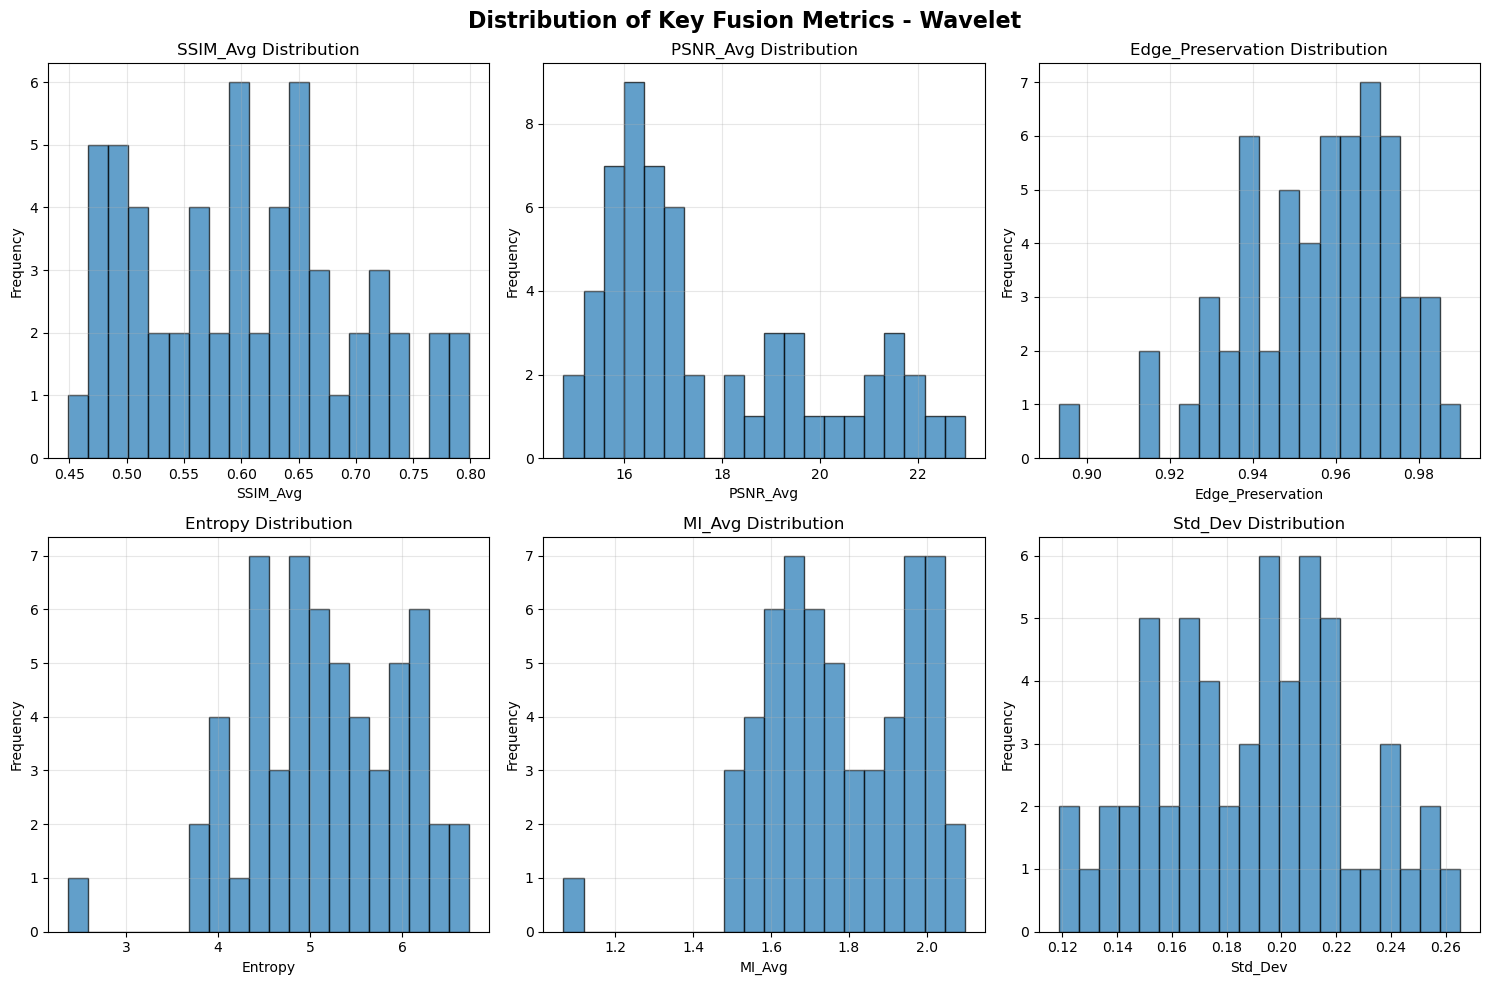

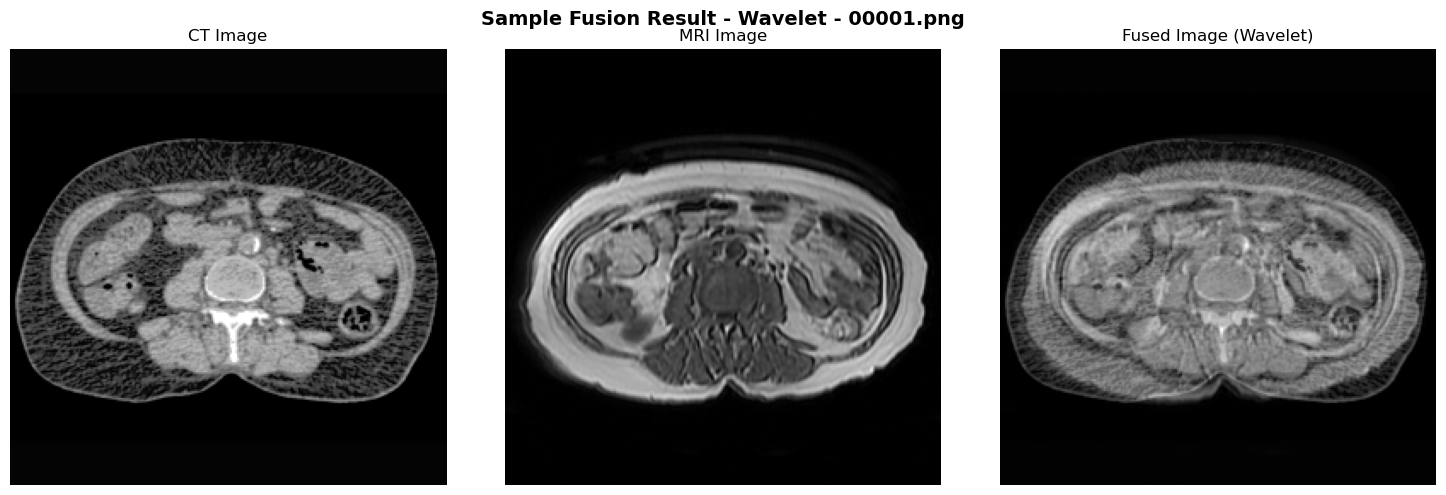


Metrics for sample 0 (00001.png):
----------------------------------------
SSIM_Avg       : 0.7054
PSNR_Avg       : 19.4869
Edge_Preservation: 0.9354
Entropy        : 5.2152
MI_Avg         : 1.8426
Std_Dev        : 0.2012


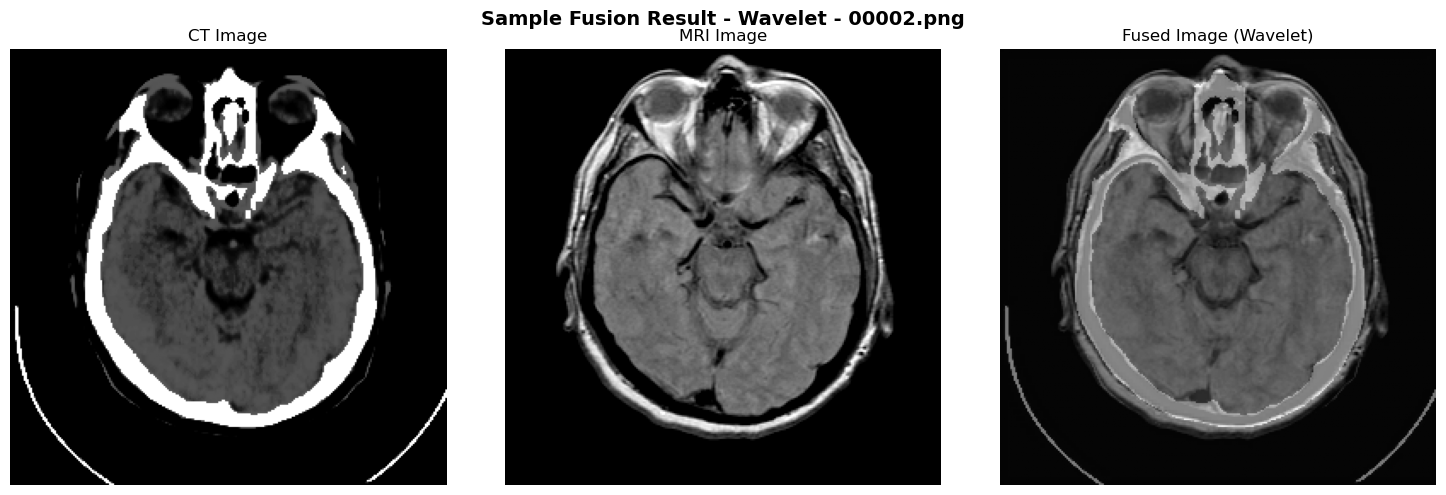


Metrics for sample 1 (00002.png):
----------------------------------------
SSIM_Avg       : 0.4958
PSNR_Avg       : 15.3261
Edge_Preservation: 0.9480
Entropy        : 4.9796
MI_Avg         : 1.6336
Std_Dev        : 0.1939


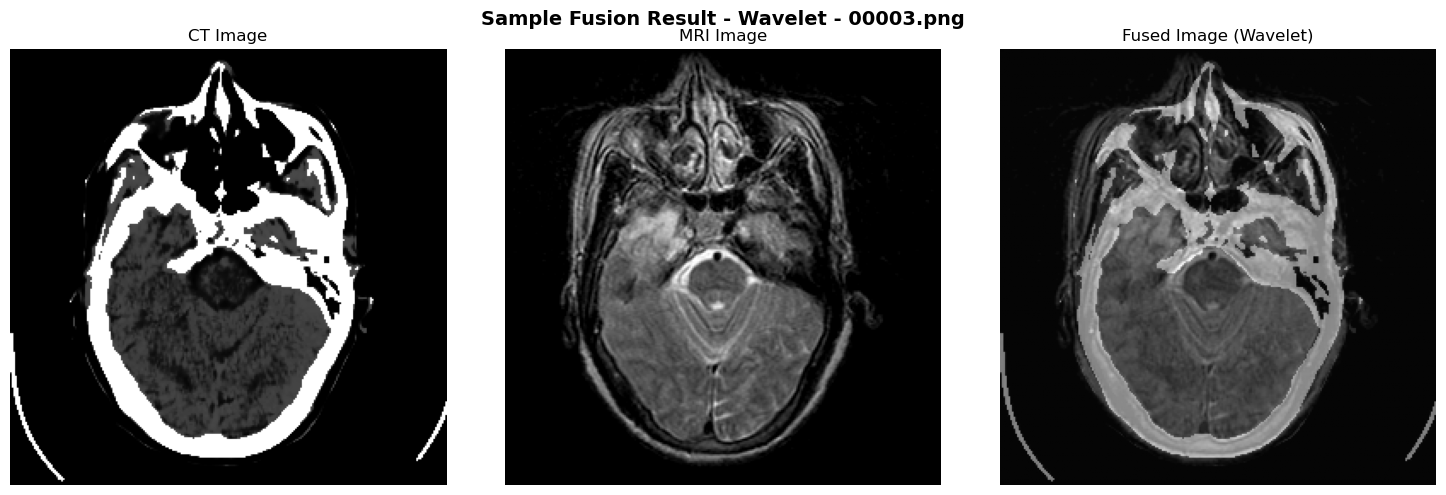


Metrics for sample 2 (00003.png):
----------------------------------------
SSIM_Avg       : 0.4843
PSNR_Avg       : 15.1721
Edge_Preservation: 0.9687
Entropy        : 4.8282
MI_Avg         : 1.6621
Std_Dev        : 0.2161


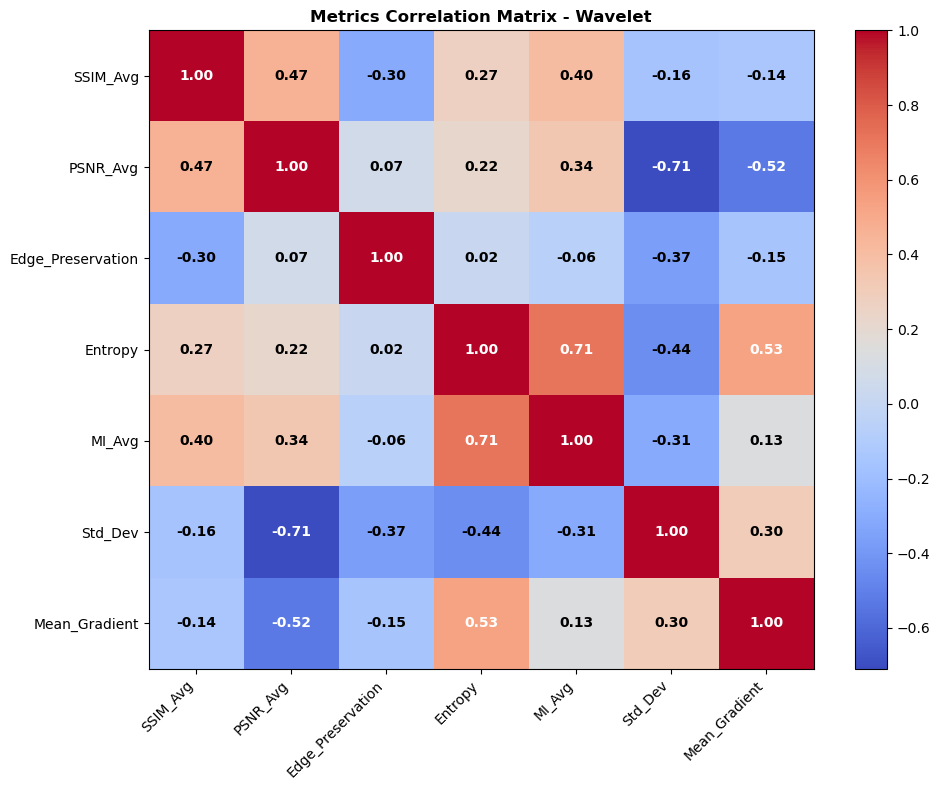


PERFORMANCE SUMMARY - WAVELET
Total samples tested: 58
Results saved to: test_results/wavelet_fusion

Best performing sample (SSIM):
  Sample: 00015.png
  SSIM_Avg: 0.7990
  PSNR_Avg: 19.4654

Worst performing sample (SSIM):
  Sample: 00011.png
  SSIM_Avg: 0.4490
  PSNR_Avg: 16.1598

✓ Detailed results saved to test_results/wavelet_fusion/detailed_metrics.csv
✓ All visualizations saved to results directory

✓ Detailed results saved to test_results/wavelet_fusion/detailed_metrics.csv
✓ All visualizations saved to results directory


In [17]:
# Visualization of Results
print("Generating visualizations...")

# 1. Metrics Distribution Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Key Fusion Metrics - Wavelet', fontsize=16, fontweight='bold')

key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev']
for i, metric in enumerate(key_metrics):
    ax = axes[i//3, i%3]
    ax.hist(metrics_df[metric], bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Distribution')
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'metrics_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Sample Fusion Results Visualization
def visualize_sample_fusion(sample_idx=0):
    """Visualize a sample fusion result."""
    if sample_idx >= len(test_results):
        print(f"Sample index {sample_idx} out of range. Max: {len(test_results)-1}")
        return
    
    sample = test_results[sample_idx]
    metrics = all_metrics[sample_idx]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample Fusion Result - Wavelet - {sample["key"]}', fontsize=14, fontweight='bold')
    
    # CT image
    axes[0].imshow(sample['ct'], cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    # MRI image
    axes[1].imshow(sample['mr'], cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    # Fused image
    axes[2].imshow(sample['fused'], cmap='gray')
    axes[2].set_title('Fused Image (Wavelet)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'sample_fusion_{sample_idx}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print metrics for this sample
    print(f"\nMetrics for sample {sample_idx} ({sample['key']}):")
    print("-" * 40)
    for metric in key_metrics:
        if metric in metrics:
            print(f"{metric:15}: {metrics[metric]:.4f}")

# Visualize first few samples
for i in range(min(3, len(test_results))):
    visualize_sample_fusion(i)

# 3. Metrics Correlation Heatmap
correlation_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg', 'Std_Dev', 'Mean_Gradient']
corr_matrix = metrics_df[correlation_metrics].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_metrics)), correlation_metrics, rotation=45, ha='right')
plt.yticks(range(len(correlation_metrics)), correlation_metrics)
plt.title('Metrics Correlation Matrix - Wavelet', fontweight='bold')

# Add correlation values
for i in range(len(correlation_metrics)):
    for j in range(len(correlation_metrics)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', 
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'metrics_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4. Performance Summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY - WAVELET")
print("="*60)
print(f"Total samples tested: {len(test_results)}")
print(f"Results saved to: {results_dir}")
print()

# Best and worst performing samples
best_ssim_idx = metrics_df['SSIM_Avg'].idxmax()
worst_ssim_idx = metrics_df['SSIM_Avg'].idxmin()

print("Best performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[best_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[best_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[best_ssim_idx, 'PSNR_Avg']:.4f}")
print()

print("Worst performing sample (SSIM):")
print(f"  Sample: {metrics_df.loc[worst_ssim_idx, 'key']}")
print(f"  SSIM_Avg: {metrics_df.loc[worst_ssim_idx, 'SSIM_Avg']:.4f}")
print(f"  PSNR_Avg: {metrics_df.loc[worst_ssim_idx, 'PSNR_Avg']:.4f}")

# Save detailed results
metrics_df.to_csv(os.path.join(results_dir, 'detailed_metrics.csv'), index=False)
print(f"\n✓ Detailed results saved to {results_dir}/detailed_metrics.csv")
print("✓ All visualizations saved to results directory")

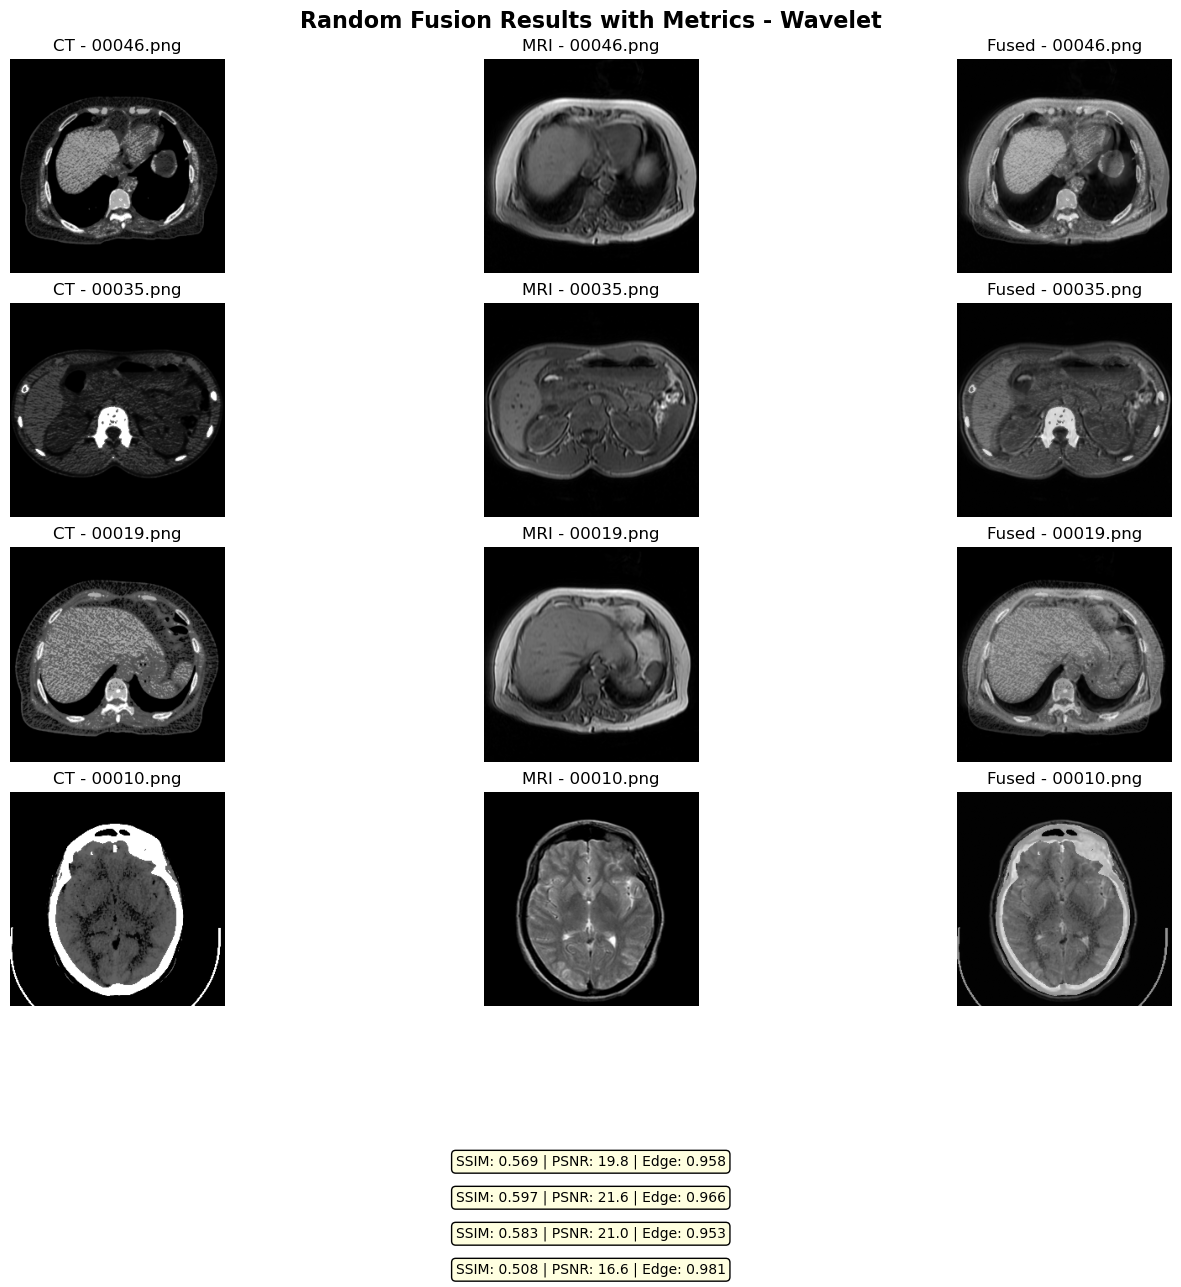


Detailed metrics for 4 random samples:

Sample 1: 00046.png
----------------------------------------
  SSIM_Avg       : 0.5689
  PSNR_Avg       : 19.8194
  Edge_Preservation: 0.9580
  Entropy        : 5.4914
  MI_Avg         : 2.0121

Sample 2: 00035.png
----------------------------------------
  SSIM_Avg       : 0.5966
  PSNR_Avg       : 21.6261
  Edge_Preservation: 0.9663
  Entropy        : 4.9449
  MI_Avg         : 1.7184

Sample 3: 00019.png
----------------------------------------
  SSIM_Avg       : 0.5830
  PSNR_Avg       : 21.0316
  Edge_Preservation: 0.9527
  Entropy        : 5.3353
  MI_Avg         : 1.7824

Sample 4: 00010.png
----------------------------------------
  SSIM_Avg       : 0.5082
  PSNR_Avg       : 16.6196
  Edge_Preservation: 0.9808
  Entropy        : 4.4748
  MI_Avg         : 1.6786


In [18]:
# 2. Random Fusion Results with Metrics
def display_random_fusion_results(test_results, all_metrics, num_samples=4, figsize=(16, 12)):
    """Display random fusion results with their evaluation metrics."""
    if len(test_results) == 0:
        print("No results available!")
        return

    # Select random indices
    random_indices = np.random.choice(len(test_results), min(num_samples, len(test_results)), replace=False)

    # Calculate grid dimensions
    cols = 3  # CT, MRI, Fused
    rows = len(random_indices)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Random Fusion Results with Metrics - Wavelet', fontsize=16, fontweight='bold')

    for row_idx, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]

        # CT Image
        axes[row_idx, 0].imshow(sample['ct'], cmap='gray')
        axes[row_idx, 0].set_title(f'CT - {sample["key"]}')
        axes[row_idx, 0].axis('off')

        # MRI Image
        axes[row_idx, 1].imshow(sample['mr'], cmap='gray')
        axes[row_idx, 1].set_title(f'MRI - {sample["key"]}')
        axes[row_idx, 1].axis('off')

        # Fused Image
        axes[row_idx, 2].imshow(sample['fused'], cmap='gray')
        axes[row_idx, 2].set_title(f'Fused - {sample["key"]}')
        axes[row_idx, 2].axis('off')

        # Add metrics text below each row
        metrics_text = f"SSIM: {metrics.get('SSIM_Avg', 0):.3f} | PSNR: {metrics.get('PSNR_Avg', 0):.1f} | Edge: {metrics.get('Edge_Preservation', 0):.3f}"

        # Add text below the subplot
        fig.text(0.5, 0.02 - (row_idx * 0.03), metrics_text,
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for metrics text
    plt.savefig(os.path.join(results_dir, 'random_fusion_results.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed metrics for random samples
    print(f"\nDetailed metrics for {len(random_indices)} random samples:")
    print("=" * 80)
    for i, idx in enumerate(random_indices):
        sample = test_results[idx]
        metrics = all_metrics[idx]
        print(f"\nSample {i+1}: {sample['key']}")
        print("-" * 40)
        key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
        for metric in key_metrics:
            if metric in metrics:
                print(f"  {metric:15}: {metrics[metric]:.4f}")

# Display random fusion results
display_random_fusion_results(test_results, all_metrics, num_samples=4)